This notebook illustrates the entire VQA pipeline using a TbD-Net. It loads the appropriate models necessary for performing the task, then allows a user to input a natural-language question and provide an image, get an answer back, and view intermediary attention masks.

In [1]:
from pathlib import Path
from itertools import groupby

import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

from tbd.module_net import load_tbd_net
from utils.clevr import load_vocab
from utils.generate_programs import load_program_generator, generate_single_program
from utils.download_pretrained_models import download
from utils.extract_features import load_feature_extractor, extract_image_feats

Now let's make sure we have all the models we need, and download them if not. We'll also load all of them here.

*Note*: if you do not have our program generator model, our TbD-Net model, and PyTorch's ResNet-101 model, these will all be downloaded.

In [2]:
vocab = load_vocab(Path('data/vocab.json'))

model_path = Path('./models')
program_generator_checkpoint = 'program_generator.pt'

tbd_net_checkpoint = 'clevr-reg-hres.pt'
if not (model_path / tbd_net_checkpoint).exists():
    download(tbd_net_checkpoint)
    
tbd_net = load_tbd_net(model_path / tbd_net_checkpoint, vocab)
program_generator = load_program_generator(model_path / program_generator_checkpoint)
feature_extractor = load_feature_extractor(model_path=model_path / 'resnet101-5d3b4d8f.pth')

In [3]:
def run_question_and_image(question, img_path):
    ''' Utility function to forward a question and image through a TbD-Net model
    and return the image and the intermediate attention masks.
    
    Parameters
    ----------
    tbd_net : torch.nn.Module
        The TbD-Net module to forward the question and image through.
        
    question : str
        A natural-language question to produce the answer to.
        
    img_path : Union[pathlib.Path, str]
        The path to the image to use to answer `question`.
        
    Returns
    -------
    Tuple[numpy.ndarray, str, List[Tuple[str, numpy.ndarray]]]
        A tuple of (img, answer, [(operation, attention), ...])
        Note that some of the intermediates will be `None` rather than a tuple, which
        indicates a break in the logic chain. For example, in the question:
            "What color is the cube to the left of the sphere and right of the cylinder?"
        We have 3 distinct chains of reasoning. We first localize the sphere and look left.
        We then localize the cylinder and look right. Thirdly, we look at the intersection
        of these two, and find the cube. We'll encounter a None at the beginning of the
        question and after the `left` and `right` operations.
    '''
    prog_var = generate_single_program(question, program_generator, vocab)
    img, feat_var = extract_image_feats(img_path, feature_extractor)
    answer, intermediaries = tbd_net.forward_and_return_intermediates(prog_var, feat_var)
    return (img, answer, intermediaries)

There's one more function to set up. We want to be able to visualize our intermediate attention masks, so we define a function that takes the intermediaries from our `run_question_and_image` function above and displays the attention masks in a logical structure.

In [4]:
def display_tree(intermediaries, interp='lanczos', img=None):
    ''' Convenience function for displaying intermediary outputs in as tree-like a
    structure as it's worth computing.
    
    Parameters
    ----------
    intermdiaries : List[Tuple[str, numpy.ndarray]]
        The [(operation, attention), ...] list to display.
        
    interp : str
        The type of interpolation to use. In our paper, we use lanczos interpolation
        for the smoothed images and nearest for the rest of our visualizations.
        Legal options are: (‘nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’, ‘cubic’).
        
    img : numpy.ndarray, shape=(r, c, 3), optional (default=None)
        The image to display under each attention mask.
        
    Returns
    -------
    Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]
        The figure and axes objects the visualization is displayed on.
    '''
    if img is not None:
        color_to_gray = [0.2126, 0.7152, 0.0722] # luminance-preserving transform
        gray = np.dot(imresize(img, (224, 224), 'bicubic'), color_to_gray)

    num_rows = intermediaries.count(None) # None indicates a break in logic
    x = intermediaries
    # get the maximum run between None entries, which is the max number of columns
    num_cols = max(len(tuple(j)) for _, j in groupby(x, key=lambda x: x is None))
    
    # create our plots
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows), 
                           squeeze=False)
    
    row, col = 0, 0
    intermediaries = intermediaries[1:] # the first operation (index 0) is always None
    for i, intermediate in enumerate(intermediaries):
        if intermediate is None:
            while col < num_cols:
                # remove all the axes that don't have a plot so we don't
                # display annoying white boxes
                ax[row, col].remove()
                col += 1
            row += 1
            col = 0
            continue
        ax[row, col].set_title(intermediate[0])
        interp = interp if interp else 'nearest'
        if img is not None:
            # if the user provides an image to underlay, display it with
            # overlaid attention masks
            ax[row, col].imshow(gray, cmap='gray')
            ax[row, col].imshow(imresize(intermediate[1], (224, 224), interp), alpha=0.5)
        else:
            # otherwise just display the attention mask
            ax[row, col].imshow(imresize(intermediate[1], (224, 224), interp))
        ax[row, col].axis('off')
        col += 1
    while col < num_cols:
        ax[row, col].remove()
        col += 1
    return (fig, ax)

In the cell below, provide your own question and image!

In [5]:
img_path = Path('data/test_im_000012.png')
question = ' '.join(['What color is the big object that is left of the large metal sphere',
                     'and right of the green metal thing?'])
img, prediction, intermediaries = run_question_and_image(question, img_path)

Let's visualize the outputs to see where our model was looking during each stage of the reasoning process.

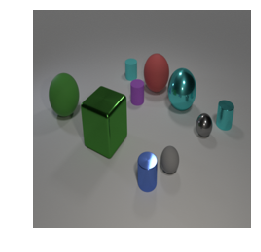

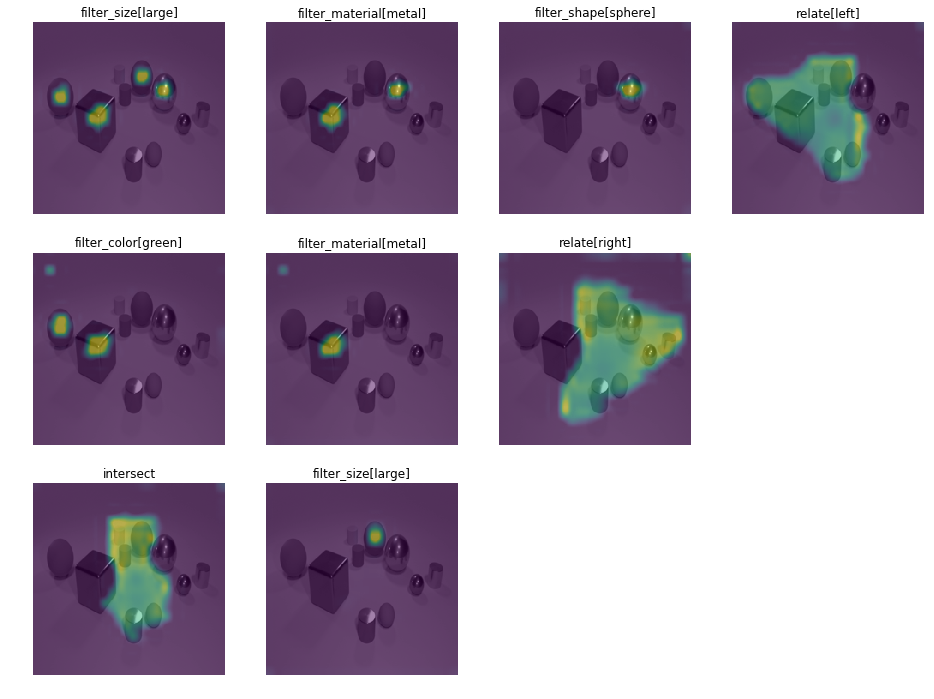

In [6]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

fig, ax = display_tree(intermediaries, interp='lanczos', img=img)

Was the model right?

In [7]:
prediction

'red'

Yes!